In [1]:
from sys import path
from os.path import relpath, realpath, abspath, join, exists
from itertools import product

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

pd.set_option('display.max_rows', 999)

In [2]:
from torchnetjson.builder import build_net

In [3]:
from thesis_v2 import dir_dict
from thesis_v2.data import load_data_helper
from thesis_v2.training.training_aux import load_training_results
from thesis_v2.training_extra.misc import count_params
from thesis_v2.models.maskcnn_polished.builder import load_modules

load_modules()

In [4]:
folder_to_check = 'scripts/training/crcns_pvc8_large'
path.insert(0, join(dir_dict['root'], folder_to_check))
from maskcnn_polished_explore_input.submit import param_iterator_obj
from maskcnn_polished_explore_input.key_utils import keygen

from maskcnn_polished.submit import param_iterator_obj as param_iterator_obj_old
from maskcnn_polished.key_utils import keygen as keygen_old

from itertools import chain

In [5]:
def load_everything():
    _df_collect = []
    for idx, param in enumerate(chain(param_iterator_obj.generate(), param_iterator_obj_old.generate())):
        if idx % 50 == 0:
            print(idx)
        
        assert param['out_channel'] == 16
        assert param['num_layer'] == 2
        assert param['kernel_size_l1'] == 7
        assert param['pooling_ksize'] == 3
        assert param['pooling_type'] == 'avg'
        
        if len(param) == 18:
#         assert param['split_seed'] == 'legacy'
        
        
        
            key = keygen(**{k: v for k, v in param.items() if k not in {'scale', 'smoothness'}})
        elif len(param) == 16:
            key = keygen_old(**{k: v for k, v in param.items() if k not in {'scale', 'smoothness'}})
        else:
            raise RuntimeError
            
        # 10 to go.
        result = load_training_results(key, return_model=False)
        # load twice, first time to get the model.
        result = load_training_results(key, return_model=True, model=build_net(result['config_extra']['model']))
        num_epochs = [len(x) for x in result['stats_all']]
        _df_collect.append(
            {
                'split_seed': str(param['split_seed']),
                
                'setup': f"{param.get('px_kept', 144)}/{param.get('downscale_ratio', 4)}",
                
                'act_fn': param['act_fn'],
                'bn_before_act': param['bn_before_act'],
                'bn_after_fc': param['bn_after_fc'],
                'shuffle_type': param['shuffle_type'],
                'loss_type': param['loss_type'],
                
                # 5 to go
                
                'scale': eval(param['scale']),
                # 
                'smoothness': float(param['smoothness']),
                # 
                
                # 1 to go
                
                
                'model_seed': param['model_seed'],
                'corr_test': result['stats_best']['stats']['test']['corr_mean'],
                'max_epoch': max(num_epochs),
                'num_param': count_params(result['model']),
            }
        )
        _df =  pd.DataFrame(_df_collect, columns=['split_seed',
                                                  'setup',
                                                  'act_fn', 'bn_before_act', 'bn_after_fc',
                                                  'shuffle_type', 'loss_type', 'scale',
                                                  'smoothness',
                                                  'model_seed',
                                                  'corr_test', 'num_param',
                                                  'max_epoch',
                                                 ])
        _df = _df.set_index(['split_seed',
                             'setup',
                             'act_fn', 'bn_before_act', 'bn_after_fc',
                             'shuffle_type', 'loss_type', 'scale',
                             'smoothness',
                             'model_seed',
                            ],verify_integrity=True)
    return _df

In [6]:
df = load_everything()

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400


In [7]:
# check max_epoch, as long as all <40000, then good.
df['max_epoch'].min(), df['max_epoch'].max()

(551, 9951)

In [8]:
# compute mean corr.
df_corr_mean = df['corr_test'].unstack('model_seed').mean(axis=1)
df_corr_std = df['corr_test'].unstack('model_seed').std(axis=1)


In [9]:
df_corr_std

split_seed  setup  act_fn    bn_before_act  bn_after_fc  shuffle_type  loss_type  scale    smoothness
0           144/4  relu      False          False        legacy        mse        0.01105  0.00002       0.000671
                                                                       poisson    0.01105  0.00002       0.004538
                                                         paired        mse        0.01105  0.00002       0.007909
                                                                       poisson    0.01105  0.00002       0.010553
                                            True         legacy        mse        0.01105  0.00002       0.015672
                                                                       poisson    0.01105  0.00002       0.017017
                                                         paired        mse        0.01105  0.00002       0.023085
                                                                       poisson    0.01105  0.00002  

In [10]:
df_corr_mean.unstack('shuffle_type')
# different shuffle type can affect a lot.

shuffle_type                                                                        legacy  \
split_seed setup act_fn   bn_before_act bn_after_fc loss_type scale   smoothness             
0          144/4 relu     False         False       mse       0.01105 0.00002     0.727516   
                                                    poisson   0.01105 0.00002     0.714077   
                                        True        mse       0.01105 0.00002     0.613049   
                                                    poisson   0.01105 0.00002     0.574182   
                          True          False       mse       0.01105 0.00002     0.729144   
                                                    poisson   0.01105 0.00002     0.717933   
                                        True        mse       0.01105 0.00002     0.640309   
                                                    poisson   0.01105 0.00002     0.598790   
                 softplus False         False       mse       0.01105 0.00002     0.676141   
                                                    poisson   0.01105 0.00002     0.746699   
                                        True        mse       0.01105 0.00002     0.384214   
                                                    poisson   0.01105 0.00002     0.528294   
                          True          False       mse       0.01105 0.00002     0.655139   
                                                    poisson   0.01105 0.00002     0.733283   
                                        True        mse       0.01105 0.00002     0.631909   
                                                    poisson   0.01105 0.00002     0.628136   
           48/2  relu     False         False       mse       0.01105 0.00002     0.707169   
                                                    poisson   0.01105 0.00002     0.712827   
                                        True        mse       0.01105 0.00002     0.674565   
                                                    poisson   0.01105 0.00002     0.670834   
                          True          False       mse       0.01105 0.00002     0.703408   
                                                    poisson   0.01105 0.00002     0.703678   
                                        True        mse       0.01105 0.00002     0.685188   
                                                    poisson   0.01105 0.00002     0.673058   
                 softplus False         False       mse       0.01105 0.00002     0.647389   
                                                    poisson   0.01105 0.00002     0.718873   
                                        True        mse       0.01105 0.00002     0.655341   
                                                    poisson   0.01105 0.00002     0.669088   
                          True          False       mse       0.01105 0.00002     0.621267   
                                                    poisson   0.01105 0.00002     0.696731   
                                        True        mse       0.01105 0.00002     0.659144   
                                                    poisson   0.01105 0.00002     0.674442   
           48/4  relu     False         False       mse       0.01105 0.00002     0.635187   
                                                    poisson   0.01105 0.00002     0.632909   
                                        True        mse       0.01105 0.00002     0.633085   
                                                    poisson   0.01105 0.00002     0.618641   
                          True          False       mse       0.01105 0.00002     0.641418   
                                                    poisson   0.01105 0.00002     0.654915   
                                        True        mse       0.01105 0.00002     0.636797   
                                                    poisson   0.01105 0.00002     0.635182   
                 softplus False         False       

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

def scatter(x, y, xlabel, ylabel, title, xlim, ylim):
    plt.close('all')
    plt.figure(figsize=(6, 5))
    plt.scatter(x, y, s=1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axis('equal')
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.plot([0,1],[0,1],linestyle='--')
    plt.title(title)
    plt.show()
    assert x.shape == y.shape and x.ndim == 1 == y.ndim
    print('number of pairs', x.size)
    print('y-x mean', (y-x).mean(), 'y-x>0 mean', ((y-x)>0).mean())
    print('y top', y.max(), 'x top', x.max())

In [12]:
# here, I need to check the effective ness of act_fn, bn_before_act, bn_after_fc, loss_type
def check_compare_one_case(series_in, label_to_unstack, xlim, ylim):
    df_unstacked = series_in.unstack(label_to_unstack)
    assert df_unstacked.shape[1] == 2
    labels = [str(x) for x in df_unstacked.columns.values]
    assert len(labels) == 2
    scatter(df_unstacked.values[:,0], df_unstacked.values[:,1], labels[0], labels[1], label_to_unstack,
           xlim, ylim)
    
    
    

In [13]:
def check_stuffs(df_in, cases_to_check, xlim, ylim):
    for case in cases_to_check:
        check_compare_one_case(df_in, case, xlim, ylim)

In [14]:
df_corr_mean.unstack('act_fn')

act_fn                                                                                    relu  \
split_seed setup bn_before_act bn_after_fc shuffle_type loss_type scale   smoothness             
0          144/4 False         False       legacy       mse       0.01105 0.00002     0.727516   
                                                        poisson   0.01105 0.00002     0.714077   
                                           paired       mse       0.01105 0.00002     0.680486   
                                                        poisson   0.01105 0.00002     0.678638   
                               True        legacy       mse       0.01105 0.00002     0.613049   
                                                        poisson   0.01105 0.00002     0.574182   
                                           paired       mse       0.01105 0.00002     0.550548   
                                                        poisson   0.01105 0.00002     0.522146   
                 True          False       legacy       mse       0.01105 0.00002     0.729144   
                                                        poisson   0.01105 0.00002     0.717933   
                                           paired       mse       0.01105 0.00002     0.695175   
                                                        poisson   0.01105 0.00002     0.682203   
                               True        legacy       mse       0.01105 0.00002     0.640309   
                                                        poisson   0.01105 0.00002     0.598790   
                                           paired       mse       0.01105 0.00002     0.594171   
                                                        poisson   0.01105 0.00002     0.555568   
           48/2  False         False       legacy       mse       0.01105 0.00002     0.707169   
                                                        poisson   0.01105 0.00002     0.712827   
                                           paired       mse       0.01105 0.00002     0.647871   
                                                        poisson   0.01105 0.00002     0.649993   
                               True        legacy       mse       0.01105 0.00002     0.674565   
                                                        poisson   0.01105 0.00002     0.670834   
                                           paired       mse       0.01105 0.00002     0.578555   
                                                        poisson   0.01105 0.00002     0.579620   
                 True          False       legacy       mse       0.01105 0.00002     0.703408   
                                                        poisson   0.01105 0.00002     0.703678   
                                           paired       mse       0.01105 0.00002     0.635318   
                                                        poisson   0.01105 0.00002     0.643801   
                               True        legacy       mse       0.01105 0.00002     0.685188   
                                                        poisson   0.01105 0.00002     0.673058   
                                           paired       mse       0.01105 0.00002     0.593384   
                                                        poisson   0.01105 0.00002     0.587115   
           48/4  False         False       legacy       mse       0.01105 0.00002     0.635187   
                                                        poisson   0.01105 0.00002     0.632909   
                                           paired       mse       0.01105 0.00002     0.548381   
                                                        poisson   0.01105 0.00002     0.560178   
                               True        legacy       mse       0.01105 0.00002     0.633085   
                                                        poisson   0.01105 0.00002     0.618641   
                                           paired       mse       0.01105 0.0000

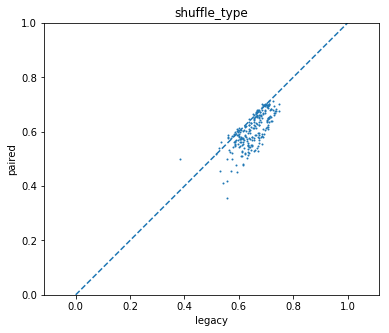

number of pairs 240
y-x mean -0.043761683188494306 y-x>0 mean 0.16666666666666666
y top 0.7145704070097721 x top 0.7467051296751963


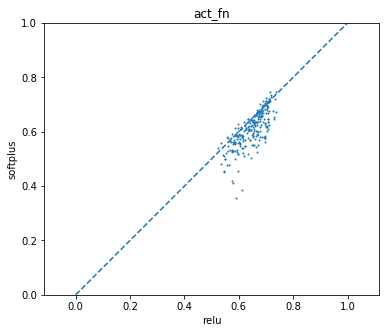

number of pairs 240
y-x mean -0.037718393313595056 y-x>0 mean 0.19166666666666668
y top 0.7467051296751963 x top 0.7371382514635721


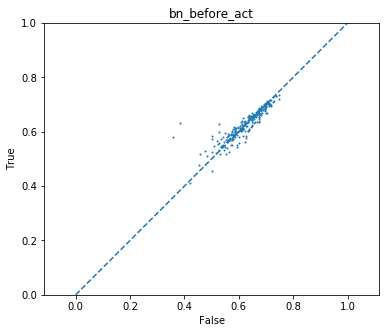

number of pairs 240
y-x mean 0.003957477418707018 y-x>0 mean 0.575
y top 0.7332827223417087 x top 0.7467051296751963


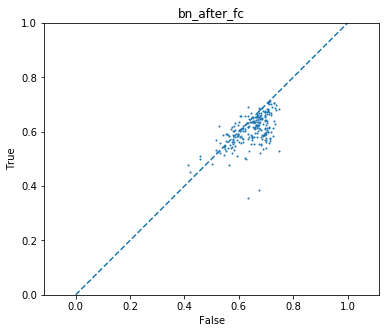

number of pairs 240
y-x mean -0.03933050127382006 y-x>0 mean 0.19166666666666668
y top 0.7122047344843546 x top 0.7467051296751963


In [15]:
check_stuffs(df_corr_mean, ['shuffle_type', 'act_fn', 'bn_before_act', 'bn_after_fc'], xlim=(0,1), ylim=(0,1))
# for input size, seems that 100 is better than 50 for state-of-the-art, but worse in general.

In [16]:
df_corr_mean.unstack('shuffle_type').unstack('split_seed')

shuffle_type                                                             legacy  \
split_seed                                                                    0   
setup act_fn   bn_before_act bn_after_fc loss_type scale   smoothness             
144/4 relu     False         False       mse       0.01105 0.00002     0.727516   
                                         poisson   0.01105 0.00002     0.714077   
                             True        mse       0.01105 0.00002     0.613049   
                                         poisson   0.01105 0.00002     0.574182   
               True          False       mse       0.01105 0.00002     0.729144   
                                         poisson   0.01105 0.00002     0.717933   
                             True        mse       0.01105 0.00002     0.640309   
                                         poisson   0.01105 0.00002     0.598790   
      softplus False         False       mse       0.01105 0.00002     0.676141   
                                         poisson   0.01105 0.00002     0.746699   
                             True        mse       0.01105 0.00002     0.384214   
                                         poisson   0.01105 0.00002     0.528294   
               True          False       mse       0.01105 0.00002     0.655139   
                                         poisson   0.01105 0.00002     0.733283   
                             True        mse       0.01105 0.00002     0.631909   
                                         poisson   0.01105 0.00002     0.628136   
48/2  relu     False         False       mse       0.01105 0.00002     0.707169   
                                         poisson   0.01105 0.00002     0.712827   
                             True        mse       0.01105 0.00002     0.674565   
                                         poisson   0.01105 0.00002     0.670834   
               True          False       mse       0.01105 0.00002     0.703408   
                                         poisson   0.01105 0.00002     0.703678   
                             True        mse       0.01105 0.00002     0.685188   
                                         poisson   0.01105 0.00002     0.673058   
      softplus False         False       mse       0.01105 0.00002     0.647389   
                                         poisson   0.01105 0.00002     0.718873   
                             True        mse       0.01105 0.00002     0.655341   
                                         poisson   0.01105 0.00002     0.669088   
               True          False       mse       0.01105 0.00002     0.621267   
                                         poisson   0.01105 0.00002     0.696731   
                             True        mse       0.01105 0.00002     0.659144   
                                         poisson   0.01105 0.00002     0.674442   
48/4  relu     False         False       mse       0.01105 0.00002     0.635187   
                                         poisson   0.01105 0.00002     0.632909   
                             True        mse       0.01105 0.00002     0.633085   
                                         poisson   0.01105 0.00002     0.618641   
               True          False       mse       0.01105 0.00002     0.641418   
                                         poisson   0.01105 0.00002     0.654915   
                             True        mse       0.01105 0.00002     0.636797   
                                         poisson   0.01105 0.00002     0.635182   
      softplus False         False       mse       0.01105 0.00002     0.575613   
                                         poisson   0.01105 0.00002     0.647403   
                             True        mse       0.01105 0.00002     0.617151   
                                         poisson   0.01105 0.00002     0.634832   
               True          False       mse       0.01105 0.00002     0.569630   
                

In [17]:
df_corr_mean.unstack('split_seed').std(axis=1).unstack('act_fn')
# in some cases, softplus has super high cross seed var. so use relu might be better.

act_fn                                                                         relu  \
setup bn_before_act bn_after_fc shuffle_type loss_type scale   smoothness             
144/4 False         False       legacy       mse       0.01105 0.00002     0.016997   
                                             poisson   0.01105 0.00002     0.012562   
                                paired       mse       0.01105 0.00002     0.008750   
                                             poisson   0.01105 0.00002     0.011551   
                    True        legacy       mse       0.01105 0.00002     0.013054   
                                             poisson   0.01105 0.00002     0.028067   
                                paired       mse       0.01105 0.00002     0.022394   
                                             poisson   0.01105 0.00002     0.025167   
      True          False       legacy       mse       0.01105 0.00002     0.015397   
                                             poisson   0.01105 0.00002     0.017355   
                                paired       mse       0.01105 0.00002     0.004331   
                                             poisson   0.01105 0.00002     0.006508   
                    True        legacy       mse       0.01105 0.00002     0.020042   
                                             poisson   0.01105 0.00002     0.014274   
                                paired       mse       0.01105 0.00002     0.009293   
                                             poisson   0.01105 0.00002     0.014951   
48/2  False         False       legacy       mse       0.01105 0.00002     0.022210   
                                             poisson   0.01105 0.00002     0.024665   
                                paired       mse       0.01105 0.00002     0.009966   
                                             poisson   0.01105 0.00002     0.010726   
                    True        legacy       mse       0.01105 0.00002     0.025308   
                                             poisson   0.01105 0.00002     0.024463   
                                paired       mse       0.01105 0.00002     0.022848   
                                             poisson   0.01105 0.00002     0.012097   
      True          False       legacy       mse       0.01105 0.00002     0.025915   
                                             poisson   0.01105 0.00002     0.022276   
                                paired       mse       0.01105 0.00002     0.014864   
                                             poisson   0.01105 0.00002     0.013672   
                    True        legacy       mse       0.01105 0.00002     0.023843   
                                             poisson   0.01105 0.00002     0.025368   
                                paired       mse       0.01105 0.00002     0.015558   
                                             poisson   0.01105 0.00002     0.018765   
48/4  False         False       legacy       mse       0.01105 0.00002     0.024268   
                                             poisson   0.01105 0.00002     0.019695   
                                paired       mse       0.01105 0.00002     0.025145   
                                             poisson   0.01105 0.00002     0.026211   
                    True        legacy       mse       0.01105 0.00002     0.025700   
                                             poisson   0.01105 0.00002     0.024758   
                                paired       mse       0.01105 0.00002     0.027283   
                                             poisson   0.01105 0.00002     0.017520   
      True          False       legacy       mse       0.01105 0.00002     0.022027   
                                             poisson   0.01105 0.00002     0.030147   
                                paired       mse       0.01105 0.00002     0.027182   
                                             poisson   0.01105 0.00002     0.019818  

In [18]:
df_corr_mean.unstack('split_seed').std(axis=1).unstack('shuffle_type')
# paired has smaller std.

shuffle_type                                                             legacy  \
setup act_fn   bn_before_act bn_after_fc loss_type scale   smoothness             
144/4 relu     False         False       mse       0.01105 0.00002     0.016997   
                                         poisson   0.01105 0.00002     0.012562   
                             True        mse       0.01105 0.00002     0.013054   
                                         poisson   0.01105 0.00002     0.028067   
               True          False       mse       0.01105 0.00002     0.015397   
                                         poisson   0.01105 0.00002     0.017355   
                             True        mse       0.01105 0.00002     0.020042   
                                         poisson   0.01105 0.00002     0.014274   
      softplus False         False       mse       0.01105 0.00002     0.016661   
                                         poisson   0.01105 0.00002     0.017100   
                             True        mse       0.01105 0.00002     0.108534   
                                         poisson   0.01105 0.00002     0.028351   
               True          False       mse       0.01105 0.00002     0.020573   
                                         poisson   0.01105 0.00002     0.019727   
                             True        mse       0.01105 0.00002     0.035569   
                                         poisson   0.01105 0.00002     0.017517   
48/2  relu     False         False       mse       0.01105 0.00002     0.022210   
                                         poisson   0.01105 0.00002     0.024665   
                             True        mse       0.01105 0.00002     0.025308   
                                         poisson   0.01105 0.00002     0.024463   
               True          False       mse       0.01105 0.00002     0.025915   
                                         poisson   0.01105 0.00002     0.022276   
                             True        mse       0.01105 0.00002     0.023843   
                                         poisson   0.01105 0.00002     0.025368   
      softplus False         False       mse       0.01105 0.00002     0.023514   
                                         poisson   0.01105 0.00002     0.026722   
                             True        mse       0.01105 0.00002     0.024637   
                                         poisson   0.01105 0.00002     0.027512   
               True          False       mse       0.01105 0.00002     0.022520   
                                         poisson   0.01105 0.00002     0.029984   
                             True        mse       0.01105 0.00002     0.027988   
                                         poisson   0.01105 0.00002     0.027067   
48/4  relu     False         False       mse       0.01105 0.00002     0.024268   
                                         poisson   0.01105 0.00002     0.019695   
                             True        mse       0.01105 0.00002     0.025700   
                                         poisson   0.01105 0.00002     0.024758   
               True          False       mse       0.01105 0.00002     0.022027   
                                         poisson   0.01105 0.00002     0.030147   
                             True        mse       0.01105 0.00002     0.027232   
                                         poisson   0.01105 0.00002     0.021104   
      softplus False         False       mse       0.01105 0.00002     0.022676   
                                         poisson   0.01105 0.00002     0.023898   
                             True        mse       0.01105 0.00002     0.030176   
                                         poisson   0.01105 0.00002     0.037496   
               True          False       mse       0.01105 0.00002     0.026276   
                                         poisson   0.01105 0.00002     0.043273   
                

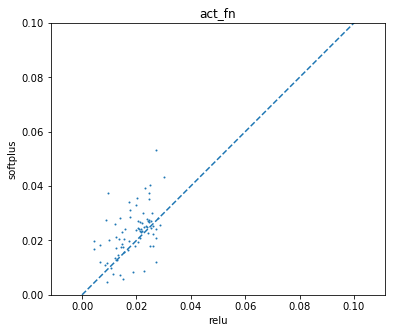

number of pairs 80
y-x mean 0.006264728454979459 y-x>0 mean 0.725
y top 0.10853351272259797 x top 0.030147459155882444


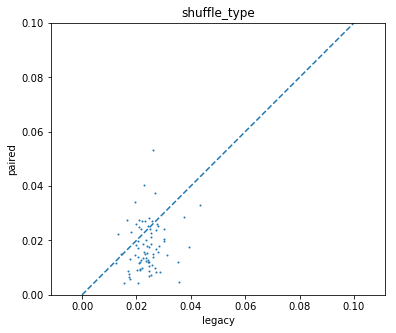

number of pairs 80
y-x mean -0.0061844570824598636 y-x>0 mean 0.2125
y top 0.10555241324330283 x top 0.10853351272259797


In [19]:
check_stuffs(df_corr_mean.unstack('split_seed').std(axis=1), ['act_fn', 'shuffle_type'], xlim=(0, 0.1), ylim=(0,0.1))

In [20]:
df_corr_mean.unstack('split_seed').unstack('setup')

# comparing 144/4 and 60/2,

# search 0.695175 and 0.72914 in the (split_seed=0,setup=144/4) column,
# and check corresponding (split_seed=0,setup=60/2) column.

# not much difference. I will simply mention this in the footnote for the paper.

split_seed                                                                           0  \
setup                                                                            144/4   
act_fn   bn_before_act bn_after_fc shuffle_type loss_type scale   smoothness             
relu     False         False       legacy       mse       0.01105 0.00002     0.727516   
                                                poisson   0.01105 0.00002     0.714077   
                                   paired       mse       0.01105 0.00002     0.680486   
                                                poisson   0.01105 0.00002     0.678638   
                       True        legacy       mse       0.01105 0.00002     0.613049   
                                                poisson   0.01105 0.00002     0.574182   
                                   paired       mse       0.01105 0.00002     0.550548   
                                                poisson   0.01105 0.00002     0.522146   
         True          False       legacy       mse       0.01105 0.00002     0.729144   
                                                poisson   0.01105 0.00002     0.717933   
                                   paired       mse       0.01105 0.00002     0.695175   
                                                poisson   0.01105 0.00002     0.682203   
                       True        legacy       mse       0.01105 0.00002     0.640309   
                                                poisson   0.01105 0.00002     0.598790   
                                   paired       mse       0.01105 0.00002     0.594171   
                                                poisson   0.01105 0.00002     0.555568   
softplus False         False       legacy       mse       0.01105 0.00002     0.676141   
                                                poisson   0.01105 0.00002     0.746699   
                                   paired       mse       0.01105 0.00002     0.625179   
                                                poisson   0.01105 0.00002     0.701142   
                       True        legacy       mse       0.01105 0.00002     0.384214   
                                                poisson   0.01105 0.00002     0.528294   
                                   paired       mse       0.01105 0.00002     0.500965   
                                                poisson   0.01105 0.00002     0.541785   
         True          False       legacy       mse       0.01105 0.00002     0.655139   
                                                poisson   0.01105 0.00002     0.733283   
                                   paired       mse       0.01105 0.00002     0.577696   
                                                poisson   0.01105 0.00002     0.667591   
                       True        legacy       mse       0.01105 0.00002     0.631909   
                                                poisson   0.01105 0.00002     0.628136   
                                   paired       mse       0.01105 0.00002     0.572795   
                                                poisson   0.01105 0.00002     0.581499   

split_seed                                                                              \
setup                                                                             48/2   
act_fn   bn_before_act bn_after_fc shuffle_type loss_type scale   smoothness             
relu     False         False       legacy       mse       0.01105 0.00002     0.707169   
                                                poisson   0.01105 0.00002     0.712827   
                                   paired       mse       0.01105 0.00002     0.647871   
                                                poisson   0.01105 0.00002     0.649993   
                       True        legacy       mse       0.01105 0.00002     0.674565   
                                                poisson   0.01105 0.00002     0.670834   
                                   pair

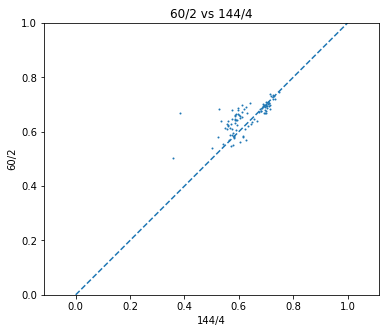

number of pairs 96
y-x mean 0.02523351973207373 y-x>0 mean 0.6354166666666666
y top 0.7467051296751963 x top 0.7466992348275214


In [21]:
# compare 144/4 and 60/2.

scatter(df_corr_mean.xs('144/4', level='setup').values,
        df_corr_mean.xs('60/2', level='setup').values,
        '144/4',
        '60/2',
        '60/2 vs 144/4',
        (0,1),
        (0,1),
       )